In [1]:
!pip install emoji
!pip install tweet-preprocessor
!pip install nltk
!pip install sentencepiece
!pip install keras
!pip install tensorflow
!pip install scikeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 2.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import preprocessor as p
import re
import random
import matplotlib.pyplot as plt
from keras.utils import plot_model

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Load the dataset
train_file_path = '/content/train.tsv'
valid_file_path = '/content/valid.tsv'
test_file_path = '/content/test.tsv'

train_data = pd.read_csv(train_file_path, sep='\t', encoding="Latin-1")
valid_data = pd.read_csv(valid_file_path, sep='\t', encoding="Latin-1")
test_data = pd.read_csv(test_file_path, sep='\t', encoding="Latin-1")


In [4]:
# Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@[^\s]+|#\w+', '', text)
    text = re.sub(r'[^\w\s\d]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

train_data['Text'] = train_data['Text'].apply(preprocess_text)
valid_data['Text'] = valid_data['Text'].apply(preprocess_text)
test_data['Text'] = test_data['Text'].apply(preprocess_text)

In [5]:
train_data['Text'].head(),valid_data['Text'].head(),test_data['Text'].head()

(0    decline coal start started natural gas took st...
 1    hillary clinton agrees john mccain voting give...
 2    health care reform legislation likely mandate ...
 3                 economic turnaround started end term
 4    chicago bear starting quarterback last 10 year...
 Name: Text, dtype: object,
 0    obama sworn office use holy bible instead kura...
 1    say organization parading social welfare organ...
 2                    say nearly half oregon child poor
 3    attack republican various program economic sti...
 4    say armed civilian stop mass shooting gun aver...
 Name: Text, dtype: object,
 0             wisconsin pace double number layoff year
 1                say john mccain done nothing help vet
 2    suzanne bonamici support plan cut choice medic...
 3    asked reporter whether he center criminal sche...
 4    past five year federal government paid 601 mil...
 Name: Text, dtype: object)

In [6]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()

# Fit label encoder on the combined labels from train, validation, and test sets
combined_labels = train_data['Label'].tolist() + valid_data['Label'].tolist() + test_data['Labels'].tolist()
label_encoder.fit(combined_labels)

# Apply label encoding to train, validation, and test sets
train_data['Encoded_Label'] = label_encoder.transform(train_data['Label'])
valid_data['Encoded_Label'] = label_encoder.transform(valid_data['Label'])
test_data['Encoded_Label'] = label_encoder.transform(test_data['Labels'])



In [7]:
unique_encoded_labels = train_data['Encoded_Label'].unique()
print(unique_encoded_labels)


[3 4 0 1 2 5]


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['Text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['Text'])
valid_sequences = tokenizer.texts_to_sequences(valid_data['Text'])
test_sequences = tokenizer.texts_to_sequences(test_data['Text'])

# Padding sequences
max_words = 100000
maxlen = 100  # Choose a maximum sequence length
train_sequences_padded = pad_sequences(train_sequences, maxlen=100, padding='post')
valid_sequences_padded = pad_sequences(valid_sequences, maxlen=100, padding='post')
test_sequences_padded = pad_sequences(test_sequences, maxlen=100, padding='post')


In [9]:
from sklearn.model_selection import train_test_split

# Define features (padded sequences) and labels (encoded labels)
X = train_sequences_padded
y = train_data['Encoded_Label']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the split datasets
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (8191, 100)
Validation data shape: (2048, 100)
Training labels shape: (8191,)
Validation labels shape: (2048,)


Epoch 1/25
256/256 [==============================] - 103s 381ms/step - loss: 1.7475 - accuracy: 0.2237 - val_loss: 1.7172 - val_accuracy: 0.2334
Epoch 2/25
256/256 [==============================] - 83s 324ms/step - loss: 1.5960 - accuracy: 0.3302 - val_loss: 1.7626 - val_accuracy: 0.2461
Epoch 3/25
256/256 [==============================] - 83s 324ms/step - loss: 1.2626 - accuracy: 0.5086 - val_loss: 1.9394 - val_accuracy: 0.2300
Epoch 4/25
256/256 [==============================] - 86s 336ms/step - loss: 0.8974 - accuracy: 0.6742 - val_loss: 2.3576 - val_accuracy: 0.2378
Epoch 5/25
256/256 [==============================] - 82s 322ms/step - loss: 0.6081 - accuracy: 0.7876 - val_loss: 2.5315 - val_accuracy: 0.2397
Epoch 6/25
64/64 [==============================] - 2s 36ms/step - loss: 1.7172 - accuracy: 0.2334
Validation accuracy: 0.2333984375


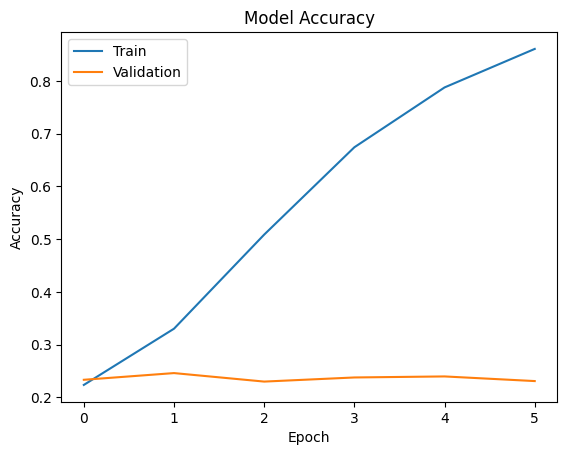

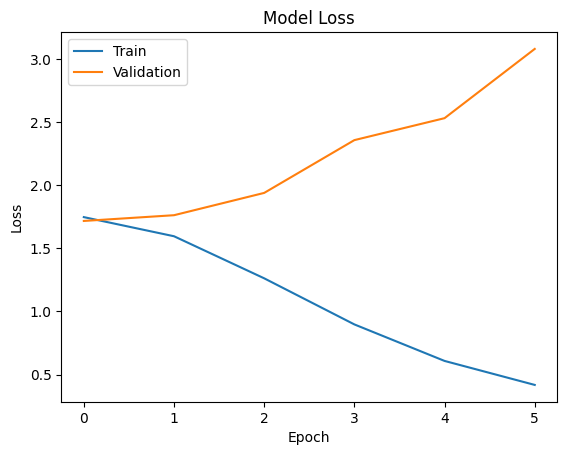

In [11]:
# # Assuming you've already padded your sequences
# maxlen = X_train.shape[1]  # Assuming X_train is your training data

# # Assuming you've already fitted the tokenizer
# max_words = tokenizer.num_words if tokenizer.num_words is not None else len(tokenizer.word_index)

from keras.layers import Dropout

# Build the model
embedding_dim = 128
num_classes = 6  # Number of classes in your classification task

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Return sequences for stacking layers
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))  # Additional dense layer for feature extraction
model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation accuracy:", val_accuracy)

# Evaluate the model on test data
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print("Test accuracy:", test_accuracy)


plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
